In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px

import ipywidgets as widgets
from IPython.display import display

from scipy.optimize import minimize

import time
from tqdm import tqdm

### 3D plot of the arm

In [2]:
def forward_kinematics_3dof(theta1, theta2, theta3, l1, l2, l3):
    x = l1 * np.cos(theta1) * np.sin(theta2) + l2 * np.cos(theta1) * np.sin(theta2 + theta3)
    y = l1 * np.sin(theta1) * np.sin(theta2) + l2 * np.sin(theta1) * np.sin(theta2 + theta3)
    z = l1 * np.cos(theta2) + l2 * np.cos(theta2 + theta3) + l3
    return x, y, z

def calculate_arm_positions(theta1, theta2, theta3, l1, l2, l3):
    p0 = np.array([0, 0, 0])
    p1 = np.array([0, 0, l3])
    x2 = l1 * np.cos(theta1) * np.sin(theta2)
    y2 = l1 * np.sin(theta1) * np.sin(theta2)
    z2 = l3 + l1 * np.cos(theta2)
    p2 = np.array([x2, y2, z2])
    p3 = np.array(forward_kinematics_3dof(theta1, theta2, theta3, l1, l2, l3))
    return np.vstack((p0, p1, p2, p3))

def generate_workspace_points(l1, l2, l3, num_points=10000):
    max_reach = l1 + l2
    
    theta1 = np.random.uniform(-np.pi, np.pi, num_points)
    theta2 = np.random.uniform(0, np.pi, num_points)
    theta3 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    
    points = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in zip(theta1, theta2, theta3)])
    
    return points

def plot_robot_arm(theta1, theta2, theta3, l1, l2, l3):
    positions = calculate_arm_positions(theta1, theta2, theta3, l1, l2, l3)
    workspace_points = generate_workspace_points(l1, l2, l3)
    
    # Create the line plot for the arm
    trace_arm = go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                             mode='lines+markers',
                             line=dict(color='blue', width=5),
                             marker=dict(size=8, color=['red', 'green', 'blue', 'cyan']),
                             name='Robot Arm')
    
    # Create scatter plot for workspace points
    trace_workspace = go.Scatter3d(x=workspace_points[:, 0], y=workspace_points[:, 1], z=workspace_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=1, color='rgba(200, 100, 100, 0.1)'),
                                   name='Workspace')
    
    # Create grid planes
    x_range = [-l1-l2, l1+l2]
    y_range = [-l1-l2, l1+l2]
    z_range = [0, l1+l2+l3]
    
    trace_xy = go.Surface(x=np.array(x_range), y=np.array(y_range), z=np.zeros((2,2)),
                          colorscale=[[0, 'rgba(200,200,200,0.3)'], [1, 'rgba(200,200,200,0.3)']], 
                          showscale=False, name='XY Plane')
    trace_xz = go.Surface(x=np.array(x_range), y=np.zeros((2,2)), z=np.array(z_range),
                          colorscale=[[0, 'rgba(150,150,150,0.3)'], [1, 'rgba(150,150,150,0.3)']], 
                          showscale=False, name='XZ Plane')
    trace_yz = go.Surface(x=np.zeros((2,2)), y=np.array(y_range), z=np.array(z_range),
                          colorscale=[[0, 'rgba(150,150,150,0.3)'], [1, 'rgba(150,150,150,0.3)']], 
                          showscale=False, name='YZ Plane')
    
    # Create the layout
    layout = go.Layout(scene=dict(aspectmode='data',
                                  xaxis=dict(range=x_range, showgrid=True, zeroline=True, title='X'),
                                  yaxis=dict(range=y_range, showgrid=True, zeroline=True, title='Y'),
                                  zaxis=dict(range=z_range, showgrid=True, zeroline=True, title='Z')),
                       title='3DOF Robot Arm Visualization with Workspace')
    
    # Create the figure and show it
    fig = go.Figure(data=[trace_arm, trace_workspace, trace_xy, trace_xz, trace_yz], layout=layout)
    fig.show()
    
    # Print workspace information
    print(f"Workspace ranges:")
    print(f"X: [{workspace_points[:, 0].min():.2f}, {workspace_points[:, 0].max():.2f}]")
    print(f"Y: [{workspace_points[:, 1].min():.2f}, {workspace_points[:, 1].max():.2f}]")
    print(f"Z: [{workspace_points[:, 2].min():.2f}, {workspace_points[:, 2].max():.2f}]")
    
    # Calculate the volume of the workspace (approximate)
    volume = (workspace_points[:, 0].max() - workspace_points[:, 0].min()) * \
             (workspace_points[:, 1].max() - workspace_points[:, 1].min()) * \
             (workspace_points[:, 2].max() - workspace_points[:, 2].min())
    print(f"Approximate workspace volume: {volume:.2f} cubic units")

# Create interactive widgets
theta1_slider = widgets.FloatSlider(value=0, min=-np.pi/2, max=np.pi/2, step=0.05, description='Theta 1')
theta2_slider = widgets.FloatSlider(value=0, min=-np.pi/2, max=np.pi/2, step=0.05, description='Theta 2')
theta3_slider = widgets.FloatSlider(value=0, min=-np.pi/2, max=np.pi/2, step=0.05, description='Theta 3')
l1_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='L1')
l2_slider = widgets.FloatSlider(value=1.5, min=0.5, max=2.0, step=0.1, description='L2')
l3_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='L3')

# Create update function
def update(theta1, theta2, theta3, l1, l2, l3):
    plot_robot_arm(theta1, theta2, theta3, l1, l2, l3)

# Create interactive output
out = widgets.interactive_output(update, {'theta1': theta1_slider, 'theta2': theta2_slider, 'theta3': theta3_slider,
                                          'l1': l1_slider, 'l2': l2_slider, 'l3': l3_slider})

# Display widgets and output
display(widgets.VBox([theta1_slider, theta2_slider, theta3_slider, l1_slider, l2_slider, l3_slider, out]))

### Generating data

In [3]:
# Generate data
num_samples = 100000  # Increased to 100k total samples
l1, l2, l3 = 1.0, 1.5, 0.5  # link lengths

theta1 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
theta2 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
theta3 = np.random.uniform(-np.pi/2, np.pi/2, num_samples)

X = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in zip(theta1, theta2, theta3)])
y = np.column_stack((theta1, theta2, theta3))

# Split the data into training (80k) and test (20k) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Plotting the data

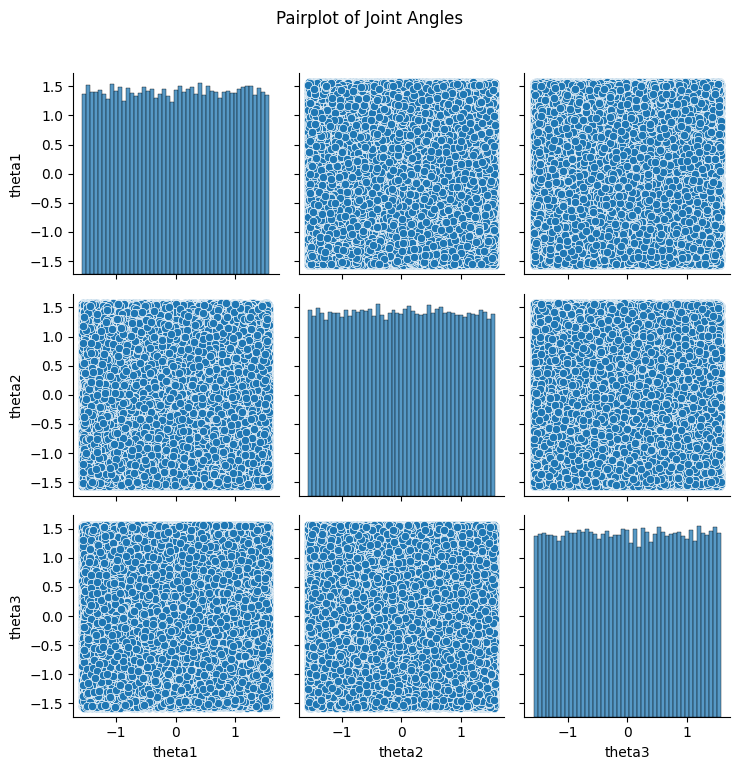

In [4]:
# 2. Pairplot of joint angles
sns.pairplot(pd.DataFrame(y, columns=['theta1', 'theta2', 'theta3']))
plt.suptitle('Pairplot of Joint Angles', y=1.02)
plt.tight_layout()
plt.show()

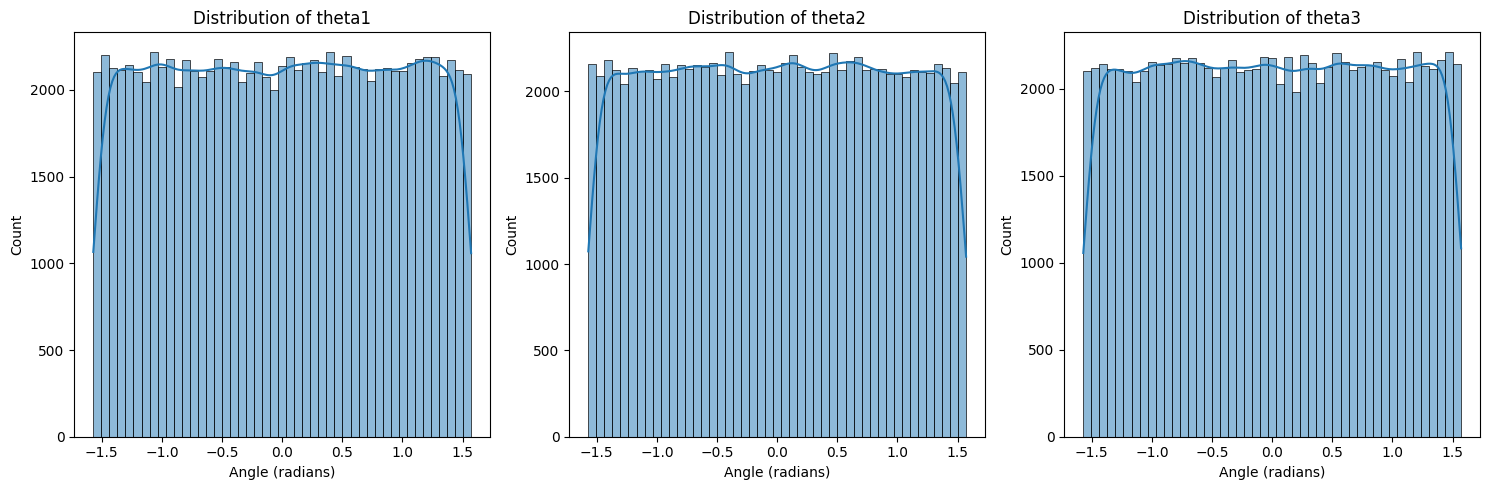

In [5]:
# 3. Histograms of joint angles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, angle in enumerate(['theta1', 'theta2', 'theta3']):
    sns.histplot(y[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {angle}')
    axes[i].set_xlabel('Angle (radians)')
plt.tight_layout()
plt.show()

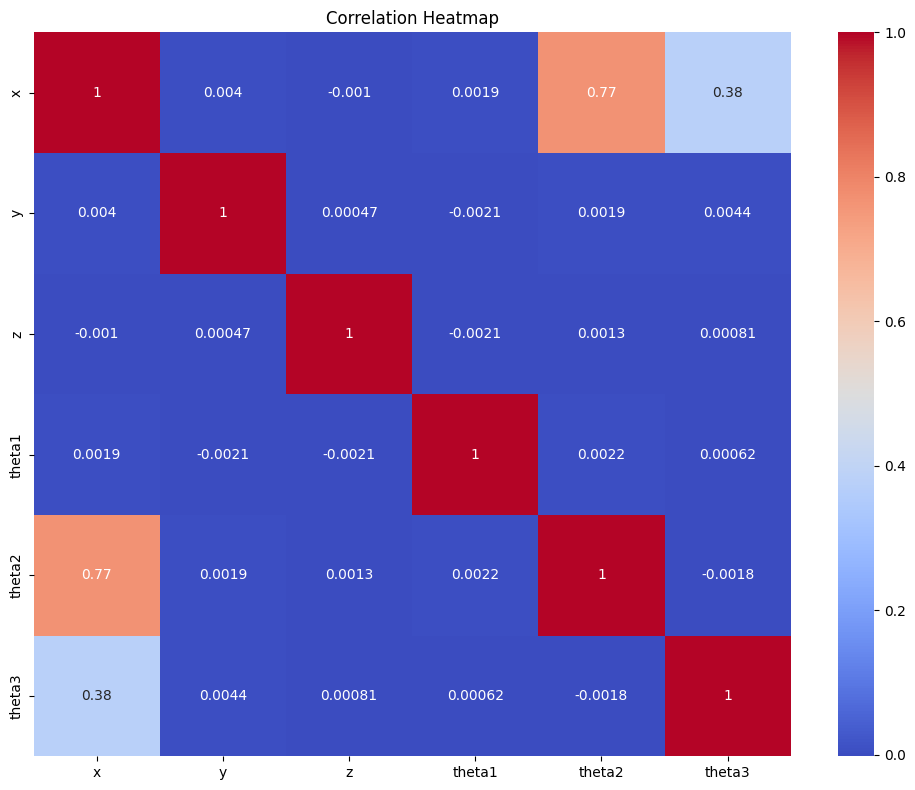

In [6]:
# 4. Heatmap of correlations between joint angles and end-effector positions
data = np.hstack((X, y))
columns = ['x', 'y', 'z', 'theta1', 'theta2', 'theta3']
corr = np.corrcoef(data.T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=columns, yticklabels=columns)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

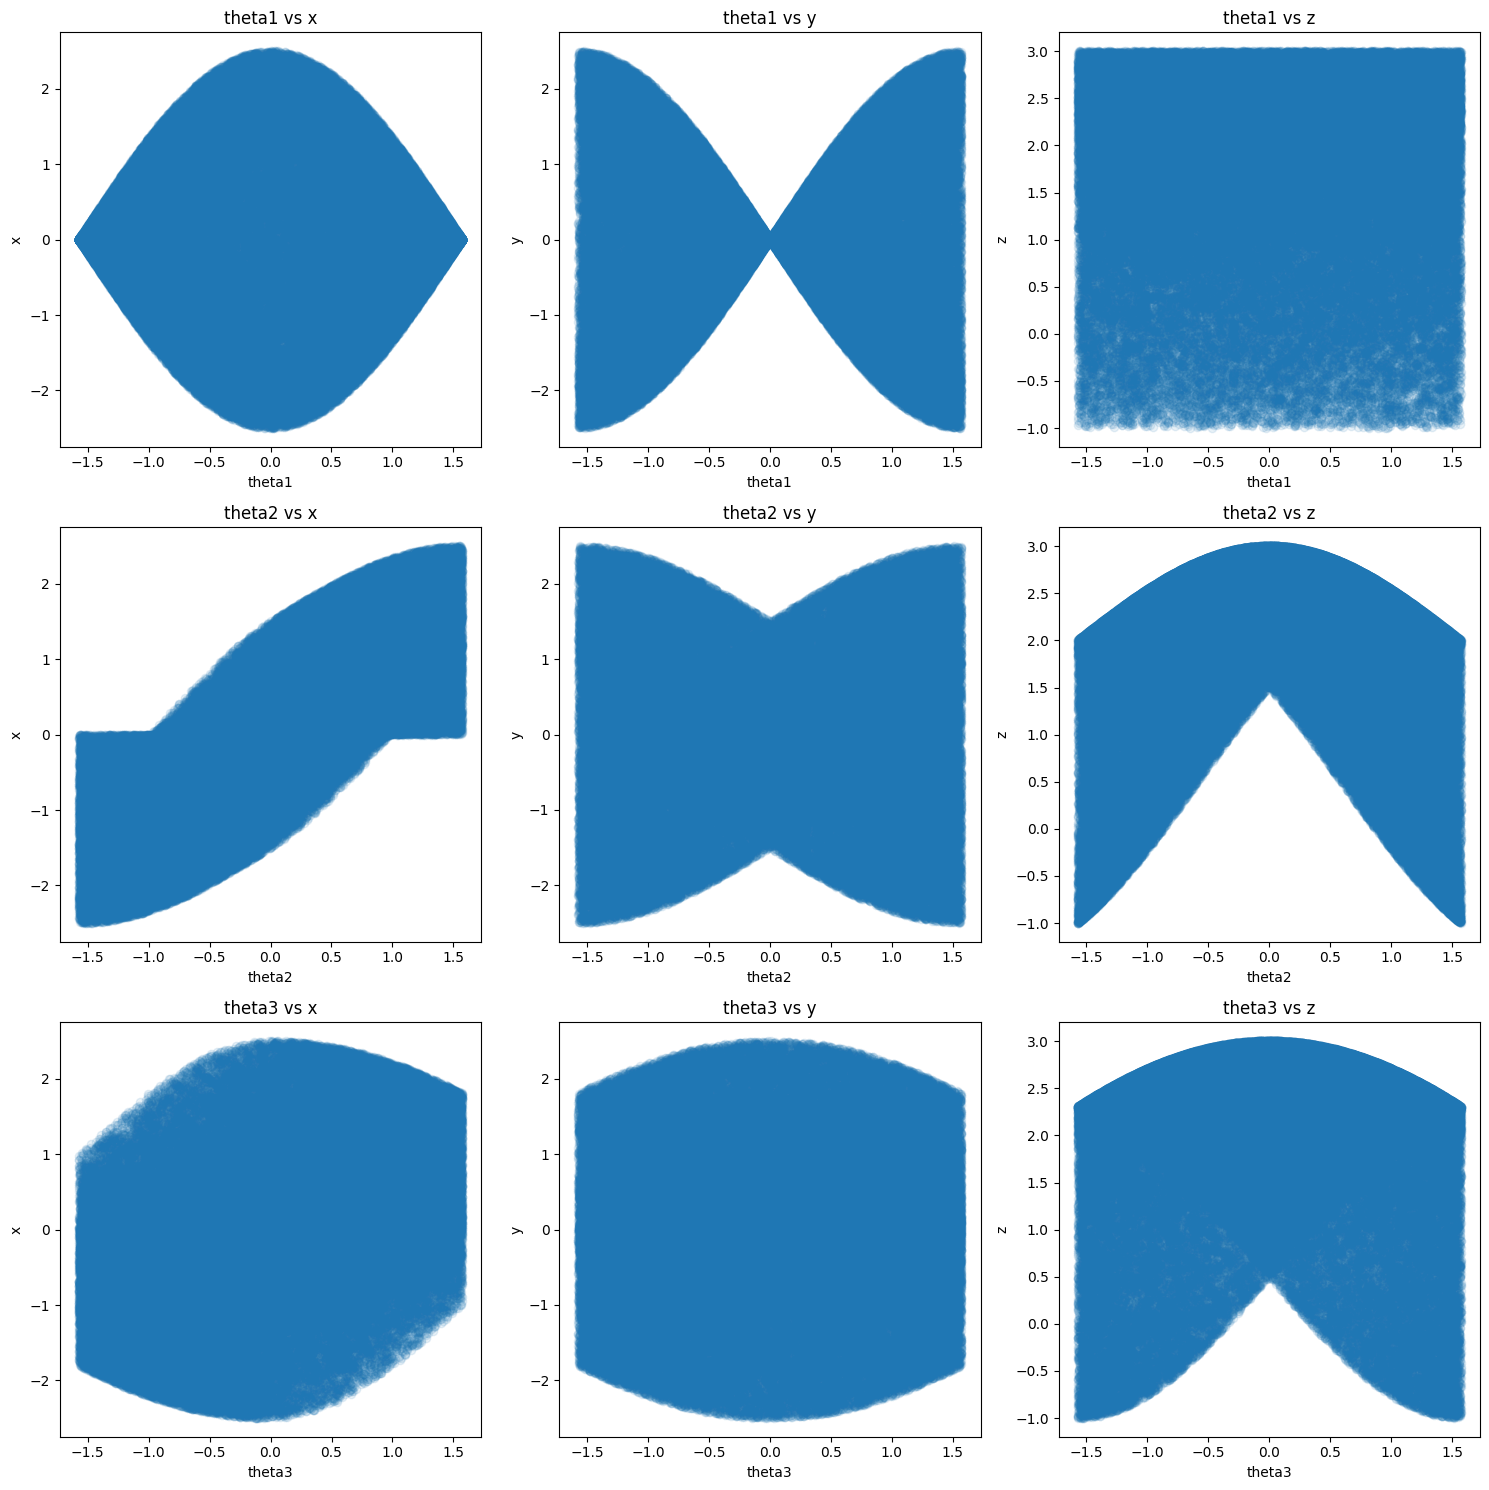

In [7]:
# 5. Joint angle vs end-effector position subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, angle in enumerate(['theta1', 'theta2', 'theta3']):
    for j, pos in enumerate(['x', 'y', 'z']):
        axes[i, j].scatter(y[:, i], X[:, j], alpha=0.1)
        axes[i, j].set_xlabel(angle)
        axes[i, j].set_ylabel(pos)
        axes[i, j].set_title(f'{angle} vs {pos}')
plt.tight_layout()
plt.show()

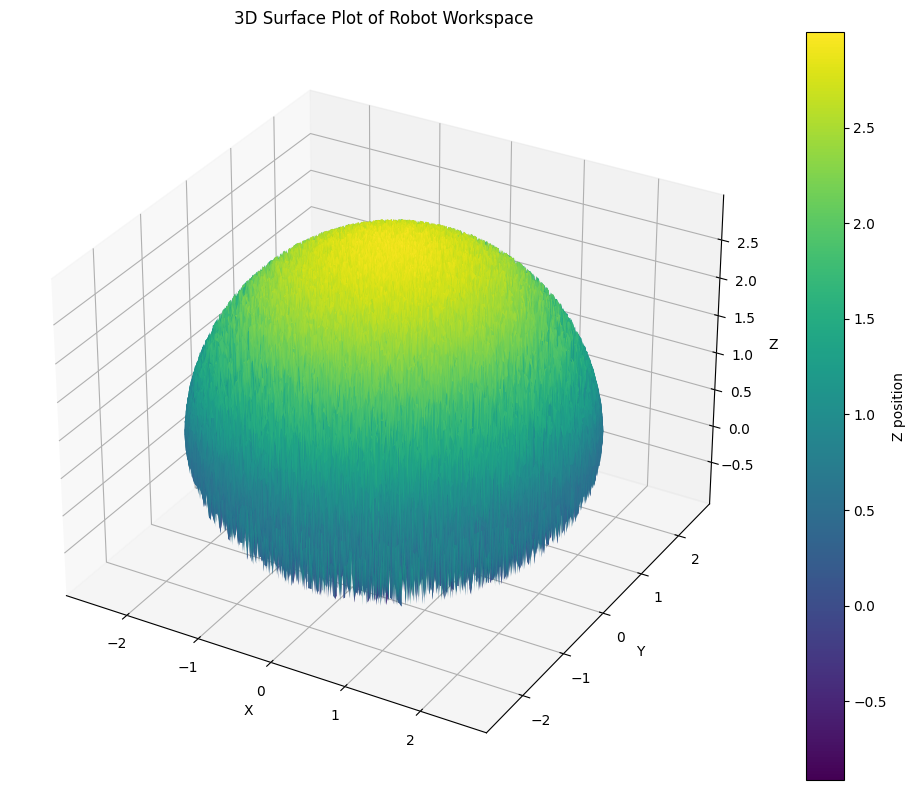

In [8]:
# 6. 3D surface plot of workspace (bonus visualization)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X[:, 0], X[:, 1], X[:, 2], cmap='viridis', edgecolor='none')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot of Robot Workspace')
plt.colorbar(surf, label='Z position')
plt.tight_layout()
plt.show()

### Make the max and min for the robot arm

In [9]:
def inverse_kinematics_cost(theta, target, l1, l2, l3):
    x, y, z = forward_kinematics_3dof(theta[0], theta[1], theta[2], l1, l2, l3)
    return np.sum((np.array([x, y, z]) - target)**2)

def inverse_kinematics_3dof(target, l1, l2, l3, initial_guess):
    result = minimize(inverse_kinematics_cost, initial_guess, 
                      args=(target, l1, l2, l3),
                      bounds=[(-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2)])
    return result.x if result.success else None

def check_redundancy(target, l1, l2, l3, num_attempts=50, position_tolerance=1e-3, angle_tolerance=1e-2):
    solutions = []
    for _ in range(num_attempts):
        initial_guess = np.random.uniform(-np.pi/2, np.pi/2, 3)
        solution = inverse_kinematics_3dof(target, l1, l2, l3, initial_guess)
        if solution is not None:
            # Calculate the end-effector position for this solution
            end_effector_pos = forward_kinematics_3dof(solution[0], solution[1], solution[2], l1, l2, l3)
            
            # Check if the end-effector position matches the target within tolerance
            if np.linalg.norm(np.array(end_effector_pos) - np.array(target)) < position_tolerance:
                # Check if this solution is unique (different joint angles)
                is_unique = all(np.linalg.norm(solution - existing_sol) > angle_tolerance for existing_sol in solutions)
                if is_unique:
                    solutions.append(solution)
    
    return solutions

def visualize_redundant_solutions(target, solutions, l1, l2, l3):
    fig = go.Figure()

    # Plot target point
    fig.add_trace(go.Scatter3d(x=[target[0]], y=[target[1]], z=[target[2]],
                               mode='markers', marker=dict(size=10, color='red'),
                               name='Target Point'))

    # Plot each solution
    for i, solution in enumerate(solutions):
        positions = calculate_arm_positions(solution[0], solution[1], solution[2], l1, l2, l3)
        fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                                   mode='lines+markers',
                                   line=dict(width=3),
                                   marker=dict(size=5),
                                   name=f'Solution {i+1}'))

    # Set layout
    fig.update_layout(scene=dict(aspectmode='data',
                                 xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      title=f'Redundant Solutions for Target ({target[0]:.2f}, {target[1]:.2f}, {target[2]:.2f})')
    fig.show()

def calculate_arm_positions(theta1, theta2, theta3, l1, l2, l3):
    p0 = np.array([0, 0, 0])
    p1 = np.array([0, 0, l3])
    x2 = l1 * np.cos(theta1) * np.sin(theta2)
    y2 = l1 * np.sin(theta1) * np.sin(theta2)
    z2 = l3 + l1 * np.cos(theta2)
    p2 = np.array([x2, y2, z2])
    p3 = np.array(forward_kinematics_3dof(theta1, theta2, theta3, l1, l2, l3))
    return np.vstack((p0, p1, p2, p3))

# Example usage
l1, l2, l3 = 1.0, 1.5, 0.5
target = [1.5, 1.0, 1.2]  # Example target point

solutions = check_redundancy(target, l1, l2, l3)
print(f"Number of unique solutions found: {len(solutions)}")
for i, sol in enumerate(solutions):
    print(f"Solution {i+1}: theta1 = {sol[0]:.4f}, theta2 = {sol[1]:.4f}, theta3 = {sol[2]:.4f}")

if len(solutions) > 1:
    print("Multiple solutions found. Visualizing...")
    visualize_redundant_solutions(target, solutions, l1, l2, l3)
elif len(solutions) == 1:
    visualize_redundant_solutions(target, solutions, l1, l2, l3)
    print("Only one solution found. No redundancy for this target point.")
else:
    print("No solutions found. The target point may be unreachable.")

# Function to generate and visualize the workspace
def generate_and_visualize_workspace(l1, l2, l3, num_points=10000):
    theta1 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    theta2 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    theta3 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    
    points = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in zip(theta1, theta2, theta3)])
    
    fig = go.Figure(data=[go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2],
                                       mode='markers',
                                       marker=dict(size=2, color=points[:, 2], colorscale='Viridis'),
                                       opacity=0.1)])
    
    fig.update_layout(scene=dict(aspectmode='data',
                                 xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      title='3DOF Robot Arm Workspace')
    fig.show()
    
    print(f"Workspace ranges:")
    print(f"X: [{points[:, 0].min():.2f}, {points[:, 0].max():.2f}]")
    print(f"Y: [{points[:, 1].min():.2f}, {points[:, 1].max():.2f}]")
    print(f"Z: [{points[:, 2].min():.2f}, {points[:, 2].max():.2f}]")

# Generate and visualize the workspace
generate_and_visualize_workspace(l1, l2, l3)

Number of unique solutions found: 1
Solution 1: theta1 = 0.5880, theta2 = 0.3290, theta3 = 1.4067


Only one solution found. No redundancy for this target point.


Workspace ranges:
X: [-2.49, 2.48]
Y: [-2.48, 2.49]
Z: [-0.99, 3.00]


### Redundancy Check

Analyzing points: 100%|██████████| 5000/5000 [01:33<00:00, 53.26point/s]


Analysis completed in 93.87 seconds

Redundancy analysis results:
0 solution(s): 5000 points (100.00%)


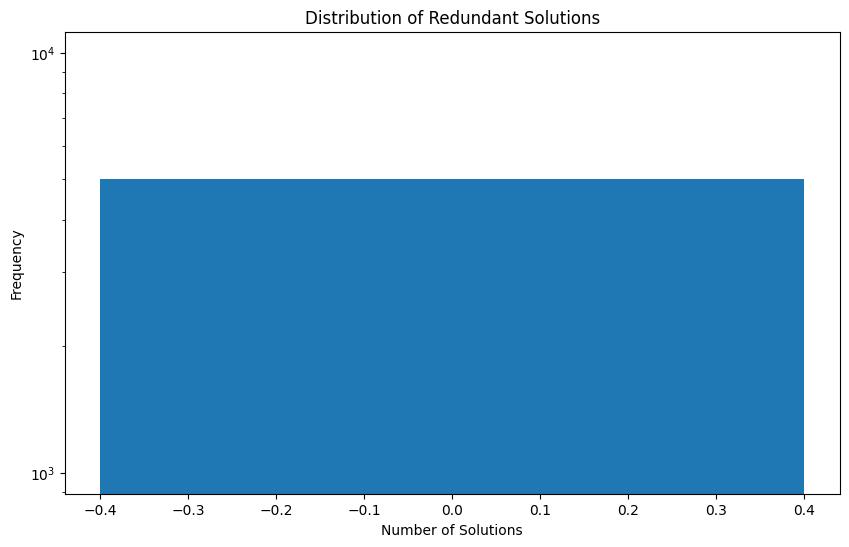

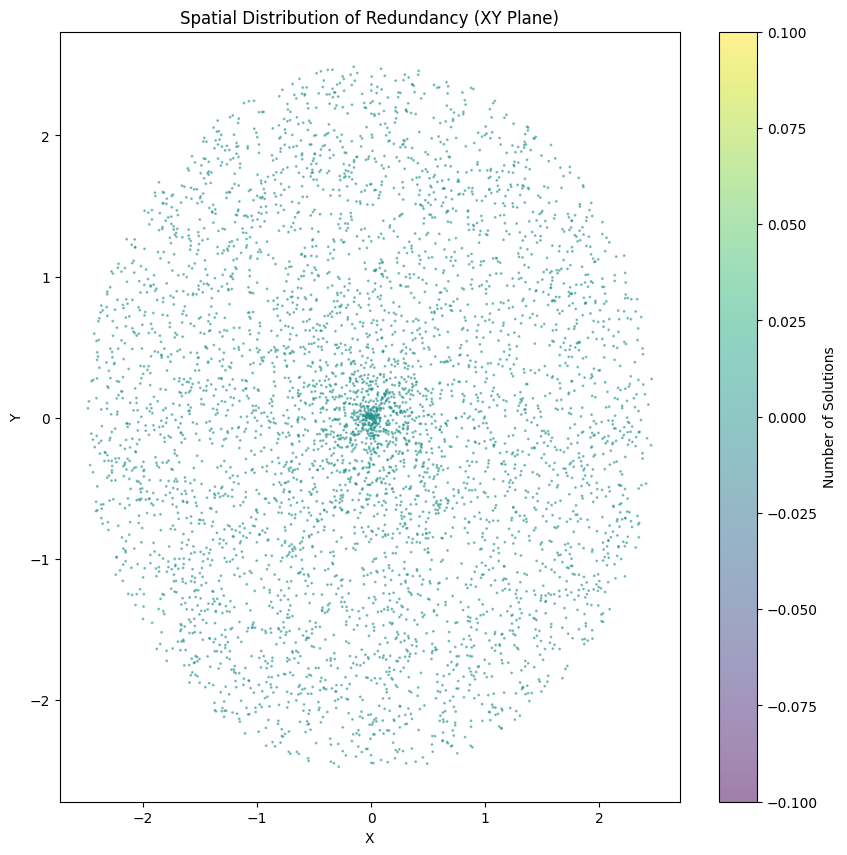

In [10]:
def forward_kinematics_3dof(theta1, theta2, theta3, l1, l2, l3):
    x = l1 * np.cos(theta1) * np.sin(theta2) + l2 * np.cos(theta1) * np.sin(theta2 + theta3)
    y = l1 * np.sin(theta1) * np.sin(theta2) + l2 * np.sin(theta1) * np.sin(theta2 + theta3)
    z = l1 * np.cos(theta2) + l2 * np.cos(theta2 + theta3) + l3
    return x, y, z

def inverse_kinematics_cost(theta, target, l1, l2, l3):
    x, y, z = forward_kinematics_3dof(theta[0], theta1[1], theta[2], l1, l2, l3)
    return np.sum((np.array([x, y, z]) - target)**2)

def inverse_kinematics_3dof(target, l1, l2, l3, initial_guess):
    result = minimize(inverse_kinematics_cost, initial_guess, 
                      args=(target, l1, l2, l3),
                      bounds=[(-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2)])
    return result.x if result.success else None

def check_redundancy(target, l1, l2, l3, num_attempts=10, position_tolerance=1e-3, angle_tolerance=1e-2):
    solutions = []
    for _ in range(num_attempts):
        initial_guess = np.random.uniform(-np.pi/2, np.pi/2, 3)
        solution = inverse_kinematics_3dof(target, l1, l2, l3, initial_guess)
        if solution is not None:
            end_effector_pos = forward_kinematics_3dof(solution[0], solution[1], solution[2], l1, l2, l3)
            if np.linalg.norm(np.array(end_effector_pos) - np.array(target)) < position_tolerance:
                is_unique = all(np.linalg.norm(solution - existing_sol) > angle_tolerance for existing_sol in solutions)
                if is_unique:
                    solutions.append(solution)
    return len(solutions)

def comprehensive_redundancy_analysis(l1, l2, l3, num_points=1000000):
    # Generate random points within the workspace
    theta1 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    theta2 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    theta3 = np.random.uniform(-np.pi/2, np.pi/2, num_points)
    
    points = np.array([forward_kinematics_3dof(t1, t2, t3, l1, l2, l3) for t1, t2, t3 in zip(theta1, theta2, theta3)])
    
    redundancy_counts = []
    start_time = time.time()
    
    for point in tqdm(points, desc="Analyzing points", unit="point"):
        redundancy_count = check_redundancy(point, l1, l2, l3)
        redundancy_counts.append(redundancy_count)
    
    end_time = time.time()
    
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    
    # Analyze results
    redundancy_counts = np.array(redundancy_counts)
    unique_counts = np.unique(redundancy_counts, return_counts=True)
    
    print("\nRedundancy analysis results:")
    for count, frequency in zip(unique_counts[0], unique_counts[1]):
        percentage = (frequency / num_points) * 100
        print(f"{count} solution(s): {frequency} points ({percentage:.2f}%)")
    
    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.bar(unique_counts[0], unique_counts[1])
    plt.title("Distribution of Redundant Solutions")
    plt.xlabel("Number of Solutions")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.show()
    
    # Visualize spatial distribution of redundancy
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(points[:, 0], points[:, 1], c=redundancy_counts, cmap='viridis', s=1, alpha=0.5)
    plt.colorbar(scatter, label='Number of Solutions')
    plt.title("Spatial Distribution of Redundancy (XY Plane)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Run the analysis
l1, l2, l3 = 1.0, 1.5, 0.5
comprehensive_redundancy_analysis(l1, l2, l3, num_points=5000)